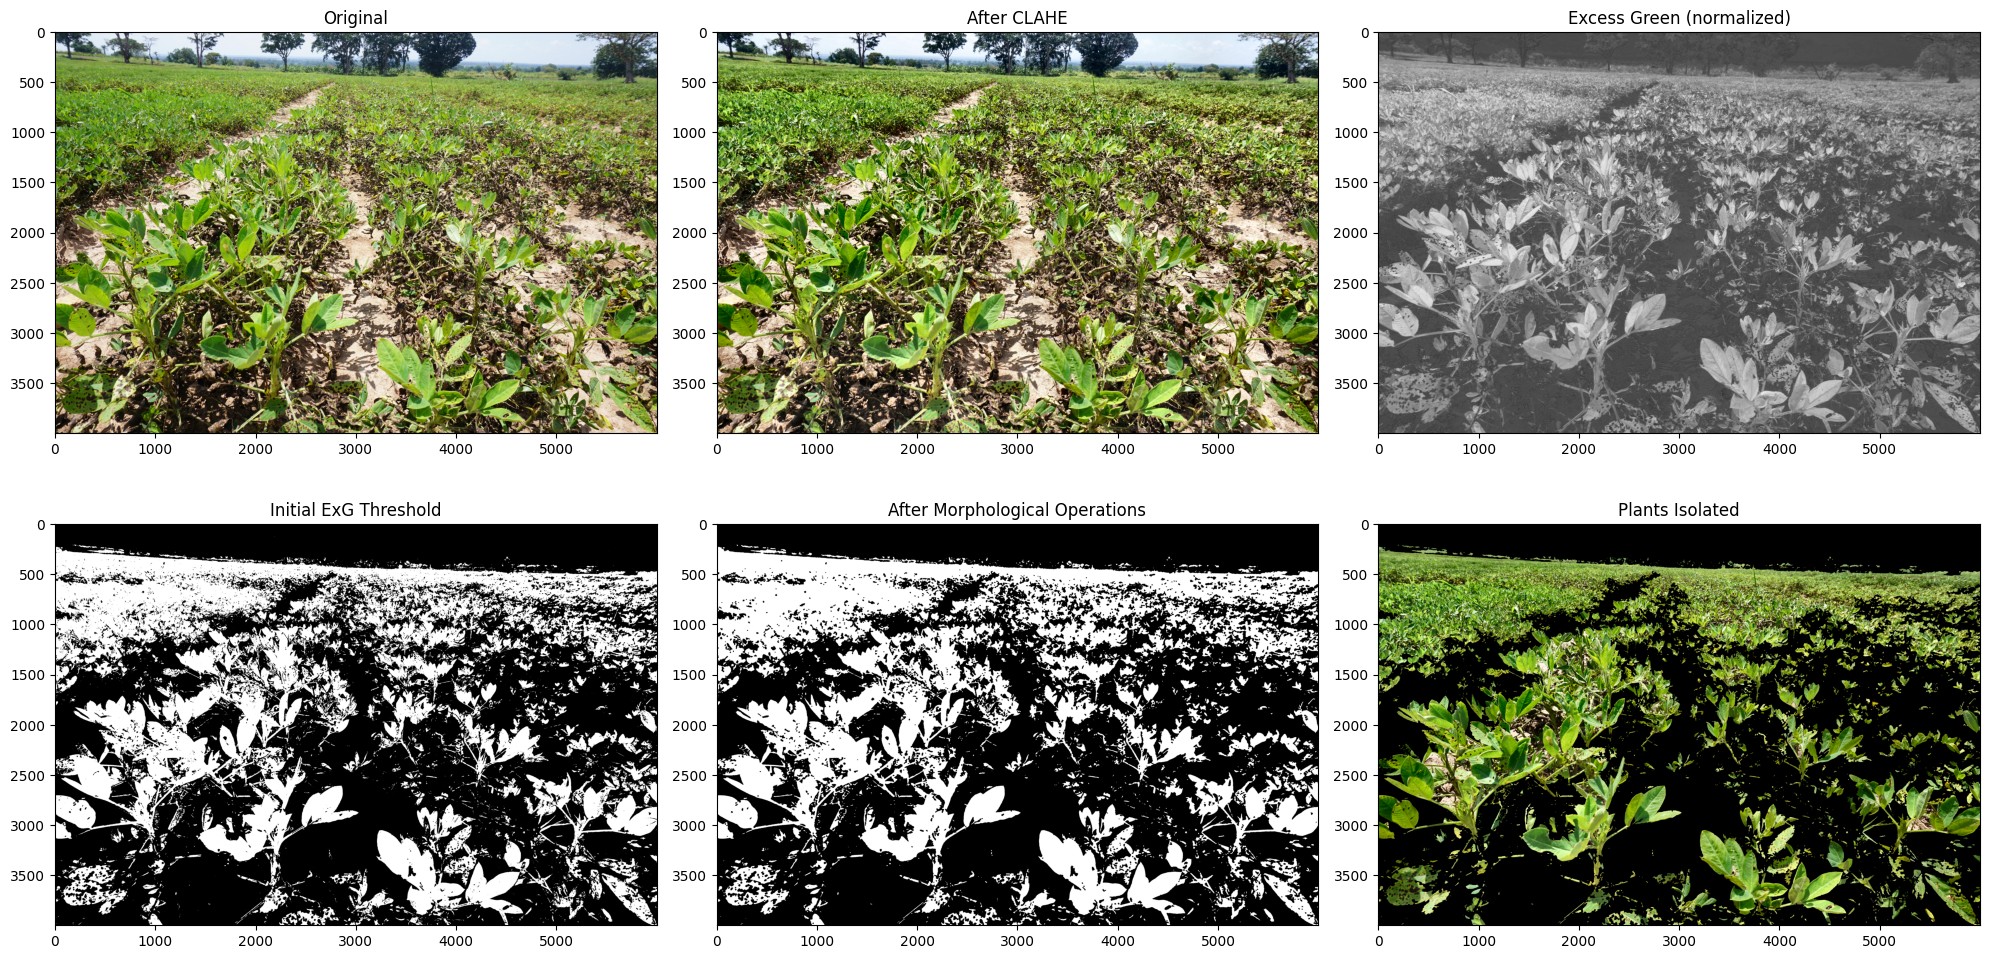

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Make sure you have uploaded your image to the Colab environment,
# or provide the correct path if it's hosted somewhere accessible.
image_path = "/content/DSC05620.JPG"  # Update to your image path in Colab

# 1) Read the original image
img = cv2.imread(image_path)
if img is None:
    raise IOError("Could not read the image. Check the path!")

# 2) Convert to LAB color space for CLAHE on the L-channel
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, a_channel, b_channel = cv2.split(lab)

# 3) Apply CLAHE to the L-channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_clahe = clahe.apply(l_channel)

# Merge back and convert to BGR
lab_clahe = cv2.merge((l_clahe, a_channel, b_channel))
img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

# 4) (Optional) Convert to HSV for inspection or color-based thresholding
hsv = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2HSV)
# You could do a color threshold here if you prefer:
# lower_green = np.array([35, 50, 20])   # Example lower bound for green
# upper_green = np.array([85, 255, 255]) # Example upper bound for green
# mask_hsv = cv2.inRange(hsv, lower_green, upper_green)

# 5) Compute an Excess Green (ExG) index from the CLAHE-enhanced BGR
b, g, r = cv2.split(img_clahe)
exg = 2.0 * g - r - b  # Simple ExG formula

# Normalize ExG for thresholding/display (0-255 range)
exg_norm = cv2.normalize(exg, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# 6) Threshold the ExG image to create a binary mask
# Adjust '128' as needed to get the best separation of plants
_, mask_exg = cv2.threshold(exg_norm, 128, 255, cv2.THRESH_BINARY)

# 7) Morphological operations to reduce noise and fill gaps
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_cleaned = cv2.morphologyEx(mask_exg, cv2.MORPH_OPEN, kernel, iterations=1)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

# 8) Find contours of the plant regions
contours, hierarchy = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 9) Option A: Create a mask that shows only the plant contours
#    (white where plants are, black elsewhere)
plant_mask = np.zeros_like(mask_cleaned)
cv2.drawContours(plant_mask, contours, -1, 255, thickness=cv2.FILLED)

# 10) Option B: Extract the plants onto a black background using bitwise operations
plants_only = cv2.bitwise_and(img_clahe, img_clahe, mask=plant_mask)

# 11) Display the results side-by-side
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB))
plt.title("After CLAHE")

plt.subplot(2, 3, 3)
plt.imshow(exg_norm, cmap='gray')
plt.title("Excess Green (normalized)")

plt.subplot(2, 3, 4)
plt.imshow(mask_exg, cmap='gray')
plt.title("Initial ExG Threshold")

plt.subplot(2, 3, 5)
plt.imshow(mask_cleaned, cmap='gray')
plt.title("After Morphological Operations")

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(plants_only, cv2.COLOR_BGR2RGB))
plt.title("Plants Isolated")

plt.tight_layout()
plt.show()


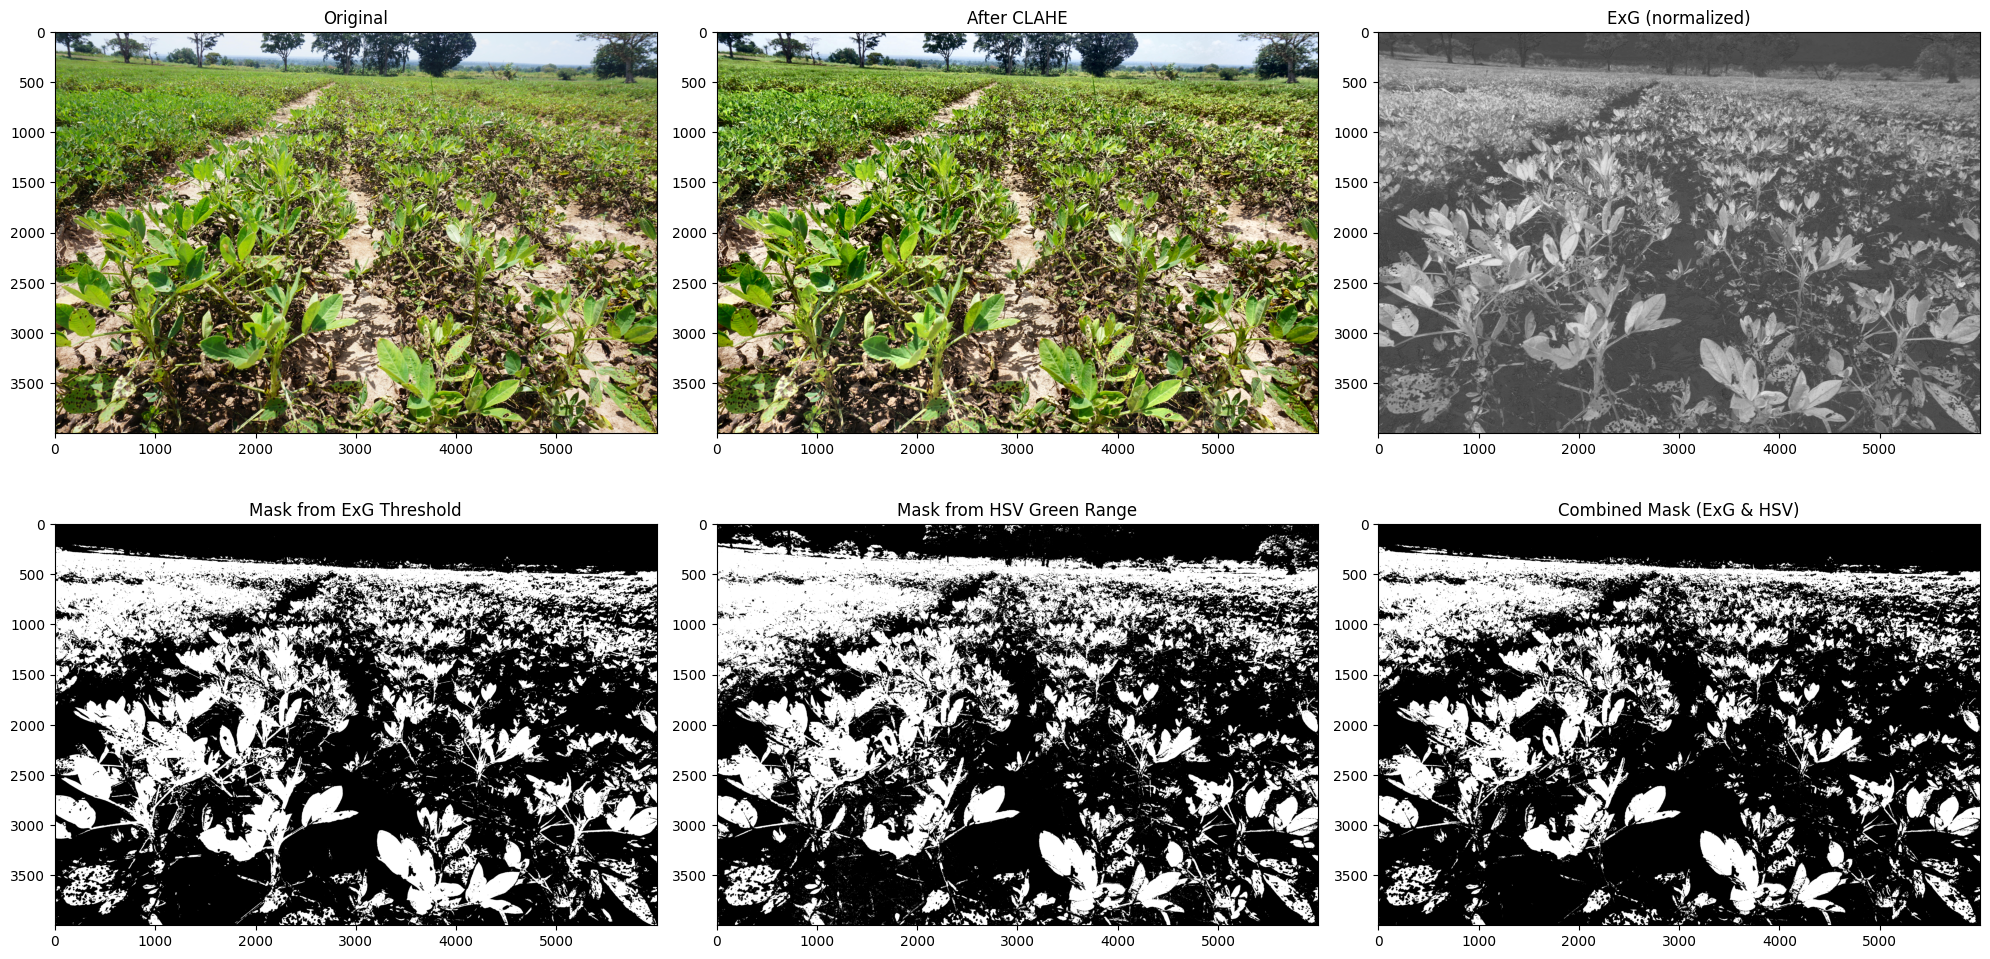

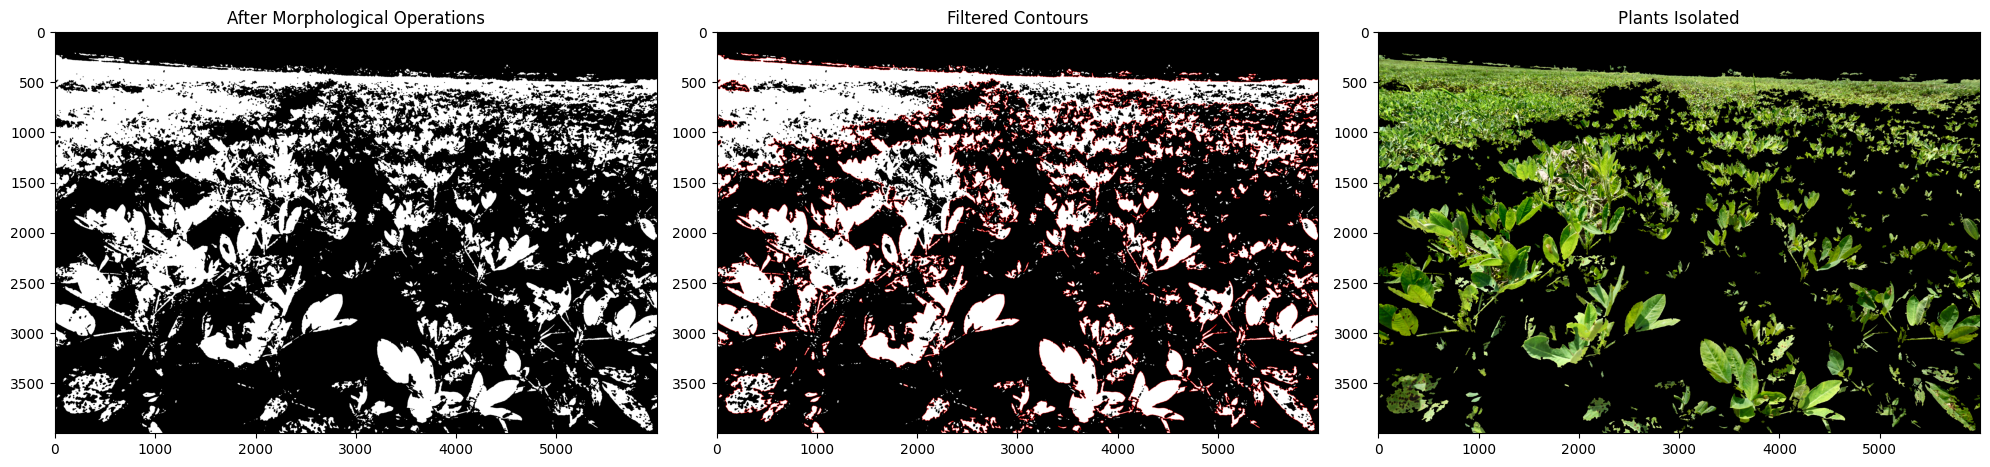

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Provide the correct path to your image in Colab
image_path = "/content/DSC05620.JPG"

# 1) Read the original image
img = cv2.imread(image_path)
if img is None:
    raise IOError("Could not read the image. Check the path!")

# 2) Convert to LAB color space for CLAHE on the L-channel
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, a_channel, b_channel = cv2.split(lab)

# Apply CLAHE to the L-channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_clahe = clahe.apply(l_channel)

# Merge and convert back to BGR
lab_clahe = cv2.merge((l_clahe, a_channel, b_channel))
img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

# 3) Compute an Excess Green (ExG) index
b, g, r = cv2.split(img_clahe)
exg = 2.0 * g - r - b  # Simple ExG formula

# (Optional) For more robust separation, use ExGR = ExG - ExR
#   ExR = 1.4*r - g
#   ExGR = ExG - ExR = 2*g - r - b - (1.4*r - g) = 3*g - 2.4*r - b
# Uncomment if you want to try ExGR:
# exr = 1.4 * r - g
# exgr = exg - exr
# exg = exgr  # Reassign exg to exgr for thresholding

# Normalize ExG for thresholding (0-255)
exg_norm = cv2.normalize(exg, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Threshold ExG
# Adjust the threshold value (e.g., 128) as needed
_, mask_exg = cv2.threshold(exg_norm, 128, 255, cv2.THRESH_BINARY)

# 4) Create an HSV-based green mask
hsv = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2HSV)

# Define lower/upper bounds for “green”
# You may need to tweak these values to capture your plants well.
lower_green = np.array([35, 40, 20])    # e.g. H=35, S=40, V=20
upper_green = np.array([85, 255, 255]) # e.g. H=85, S=255, V=255

mask_hsv = cv2.inRange(hsv, lower_green, upper_green)

# 5) Combine ExG mask and HSV mask to get a stronger "plant" signal
combined_mask = cv2.bitwise_and(mask_exg, mask_hsv)

# 6) Morphological operations to reduce noise & fill gaps
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_cleaned = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

# 7) Find external contours on the cleaned mask
contours, hierarchy = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 8) Filter out small or very large contours by area (tune these area thresholds)
min_area = 500   # Example minimum area (in pixels) for a plant region
max_area = 1e7   # Example max area to discard extremely large regions if needed

filtered_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if min_area < area < max_area:
        filtered_contours.append(cnt)

# 9) Draw filtered contours onto a new mask
plant_mask = np.zeros_like(mask_cleaned)
cv2.drawContours(plant_mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

# 10) Extract the plants using the final mask
plants_only = cv2.bitwise_and(img_clahe, img_clahe, mask=plant_mask)

# 11) Visualization
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB))
plt.title("After CLAHE")

plt.subplot(2, 3, 3)
plt.imshow(exg_norm, cmap='gray')
plt.title("ExG (normalized)")

plt.subplot(2, 3, 4)
plt.imshow(mask_exg, cmap='gray')
plt.title("Mask from ExG Threshold")

plt.subplot(2, 3, 5)
plt.imshow(mask_hsv, cmap='gray')
plt.title("Mask from HSV Green Range")

plt.subplot(2, 3, 6)
plt.imshow(combined_mask, cmap='gray')
plt.title("Combined Mask (ExG & HSV)")

plt.tight_layout()
plt.show()

# Show final morphological cleaning, contour filtering, and plant isolation
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.imshow(mask_cleaned, cmap='gray')
plt.title("After Morphological Operations")

plt.subplot(1, 3, 2)
final_mask_display = cv2.drawContours(cv2.cvtColor(mask_cleaned, cv2.COLOR_GRAY2BGR).copy(),
                                      filtered_contours, -1, (0,0,255), 2)
plt.imshow(cv2.cvtColor(final_mask_display, cv2.COLOR_BGR2RGB))
plt.title("Filtered Contours")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(plants_only, cv2.COLOR_BGR2RGB))
plt.title("Plants Isolated")

plt.tight_layout()
plt.show()


In [ ]:
import subprocess
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense
from skimage.feature import hog, local_binary_pattern, greycomatrix, greycoprops

# --- Step 1: Download the Dataset ---
def download_dataset():
    """Download the dataset from Google Drive using gdown."""
    folder_id = "1iWwH6P2Eag2vlzGp2VwnDO_jOewBDl1k"
    subprocess.run(["gdown", "--id", folder_id, "--folder"])
    print("Dataset downloaded successfully.")

# --- Step 2: Data Cleaning ---
def clean_data(dataset_path):
    """Remove corrupted or unreadable images from the dataset."""
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        os.remove(img_path)
                        print(f"Removed corrupted image: {img_path}")
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    os.remove(img_path)
    print("Data cleaning completed.")

# --- Step 3: Load and Resize Images ---
def load_and_resize_images(dataset_path, target_size=(256, 256)):
    """Load images from the dataset and resize them to a target size."""
    images = []
    labels = []
    classes = os.listdir(dataset_path)
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        if os.path.isdir(cls_path):
            for img_file in os.listdir(cls_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(cls_path, img_file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img_resized = cv2.resize(img, target_size)
                        images.append(img_resized)
                        labels.append(cls)
    return images, labels

# --- Step 4: Feature Extraction Functions ---
# Traditional Feature Extraction
def extract_hog_features(image):
    """Extract Histogram of Oriented Gradients (HOG) features."""
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = hog(image_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True)
    return features

def extract_rgb_histogram(image):
    """Extract RGB color histogram."""
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_hsv_histogram(image):
    """Extract HSV color histogram."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lab_histogram(image):
    """Extract LAB color histogram."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    hist = cv2.calcHist([lab], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(image):
    """Extract Local Binary Pattern (LBP) features."""
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(image_gray, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp, bins=256, range=(0, 255))
    return hist

def extract_edge_histogram(image):
    """Extract edge histogram using Canny edge detector."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    hist, _ = np.histogram(edges, bins=256, range=(0, 255))
    return hist

def extract_glcm_features(image):
    """Extract texture features using Gray-Level Co-occurrence Matrix (GLCM)."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    return np.array([contrast, dissimilarity, homogeneity, energy, correlation])

# Deep Learning Feature Extraction
def extract_dl_features_batch(images, model_name):
    """Extract features using a pre-trained deep learning model in batches."""
    if model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False)
        preprocess = preprocess_vgg
    elif model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False)
        preprocess = preprocess_resnet
    elif model_name == 'inceptionv3':
        base_model = InceptionV3(weights='imagenet', include_top=False)
        preprocess = preprocess_inception
    elif model_name == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False)
        preprocess = preprocess_mobilenet
    elif model_name == 'densenet121':
        base_model = DenseNet121(weights='imagenet', include_top=False)
        preprocess = preprocess_densenet
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    x = GlobalAveragePooling2D()(base_model.output)
    model = Model(inputs=base_model.input, outputs=x)
    preprocessed_images = [preprocess(cv2.resize(img, (224, 224))) for img in images]
    preprocessed_images = np.array(preprocessed_images)
    features = model.predict(preprocessed_images, batch_size=32)
    return features

# --- Step 5: Preprocess Images for CNN ---
def preprocess_images_for_cnn(images, target_size=(224, 224)):
    """Preprocess images for CNN training by resizing and normalizing."""
    preprocessed = [cv2.resize(img, target_size) for img in images]
    preprocessed = np.array(preprocessed) / 255.0  # Normalize to [0,1]
    return preprocessed

# --- Step 6: Build CNN Model ---
def build_cnn(input_shape, num_classes):
    """Build a simple CNN model for classification."""
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Main Execution ---
if __name__ == "__main__":
    dataset_path = "Groundnut Leaf Spot"

    # Download dataset if it doesn't exist
    if not os.path.exists(dataset_path):
        download_dataset()
    else:
        print("Dataset already downloaded.")

    # Clean the dataset
    clean_data(dataset_path)

    # Load and resize images
    print("Loading and resizing images...")
    images, labels = load_and_resize_images(dataset_path, target_size=(256, 256))
    if not images:
        raise ValueError("No valid images loaded from the dataset.")

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(labels)
    num_classes = len(np.unique(y))

    # Split data into training and testing sets
    indices = np.arange(len(images))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

    # Extract features (10 methods)
    print("Extracting features...")
    X_hog = np.array([extract_hog_features(images[i]) for i in range(len(images))])
    X_rgb_hist = np.array([extract_rgb_histogram(images[i]) for i in range(len(images))])
    X_hsv_hist = np.array([extract_hsv_histogram(images[i]) for i in range(len(images))])
    X_lab_hist = np.array([extract_lab_histogram(images[i]) for i in range(len(images))])
    X_lbp = np.array([extract_lbp_features(images[i]) for i in range(len(images))])
    X_edge_hist = np.array([extract_edge_histogram(images[i]) for i in range(len(images))])
    X_glcm = np.array([extract_glcm_features(images[i]) for i in range(len(images))])
    X_vgg16 = extract_dl_features_batch(images, 'vgg16')
    X_resnet50 = extract_dl_features_batch(images, 'resnet50')
    X_inceptionv3 = extract_dl_features_batch(images, 'inceptionv3')

    # Split features for training and testing
    feature_sets = {
        'hog': X_hog,
        'rgb_hist': X_rgb_hist,
        'hsv_hist': X_hsv_hist,
        'lbp': X_lbp,
        'vgg16': X_vgg16
    }
    X_train = {key: val[train_indices] for key, val in feature_sets.items()}
    X_test = {key: val[test_indices] for key, val in feature_sets.items()}
    y_train = y[train_indices]
    y_test = y[test_indices]

    # Train and evaluate models (7 models)
    print("\nTraining and evaluating models...")

    # 1. SVM on HOG features
    svm_model = SVC(kernel='linear', class_weight='balanced')
    svm_model.fit(X_train['hog'], y_train)
    y_pred_svm = svm_model.predict(X_test['hog'])
    print("\nSVM on HOG features:")
    print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

    # 2. Random Forest on RGB histogram
    rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
    rf_model.fit(X_train['rgb_hist'], y_train)
    y_pred_rf = rf_model.predict(X_test['rgb_hist'])
    print("\nRandom Forest on RGB histogram:")
    print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

    # 3. K-NN on LBP features
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train['lbp'], y_train)
    y_pred_knn = knn_model.predict(X_test['lbp'])
    print("\nK-NN on LBP features:")
    print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

    # 4. AdaBoost on HOG features
    ada_model = AdaBoostClassifier(n_estimators=50)
    ada_model.fit(X_train['hog'], y_train)
    y_pred_ada = ada_model.predict(X_test['hog'])
    print("\nAdaBoost on HOG features:")
    print(classification_report(y_test, y_pred_ada, target_names=le.classes_))

    # 5. Gradient Boosting on HSV histogram
    gb_model = GradientBoostingClassifier(n_estimators=100)
    gb_model.fit(X_train['hsv_hist'], y_train)
    y_pred_gb = gb_model.predict(X_test['hsv_hist'])
    print("\nGradient Boosting on HSV histogram:")
    print(classification_report(y_test, y_pred_gb, target_names=le.classes_))

    # 6. MLP on VGG16 features
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
    mlp_model.fit(X_train['vgg16'], y_train)
    y_pred_mlp = mlp_model.predict(X_test['vgg16'])
    print("\nMLP on VGG16 features:")
    print(classification_report(y_test, y_pred_mlp, target_names=le.classes_))

    # 7. CNN on raw images
    print("\nTraining CNN on raw images...")
    train_images = [images[i] for i in train_indices]
    test_images = [images[i] for i in test_indices]
    X_train_cnn = preprocess_images_for_cnn(train_images)
    X_test_cnn = preprocess_images_for_cnn(test_images)
    cnn_model = build_cnn((224, 224, 3), num_classes)
    cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test))
    y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
    print("\nCNN on raw images:")
    print(classification_report(y_test, y_pred_cnn, target_names=le.classes_))

    print("Script execution completed.")

ImportError: cannot import name 'greycomatrix' from 'skimage.feature' (/usr/local/lib/python3.11/dist-packages/skimage/feature/__init__.py)